In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

2.3.0


# Get data

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\kevin\\.keras\\datasets\\auto-mpg.data'

In [3]:
# import using pandas
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Preprocess data

In [4]:
# check for null values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# some rows in HP is null, remove those rows
dataset = dataset.dropna()

In [6]:
# origin coulmn is categorical, not numeric, so convert to one hot
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

In [7]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [8]:
# split to 0.8 train and 0.2 test set
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

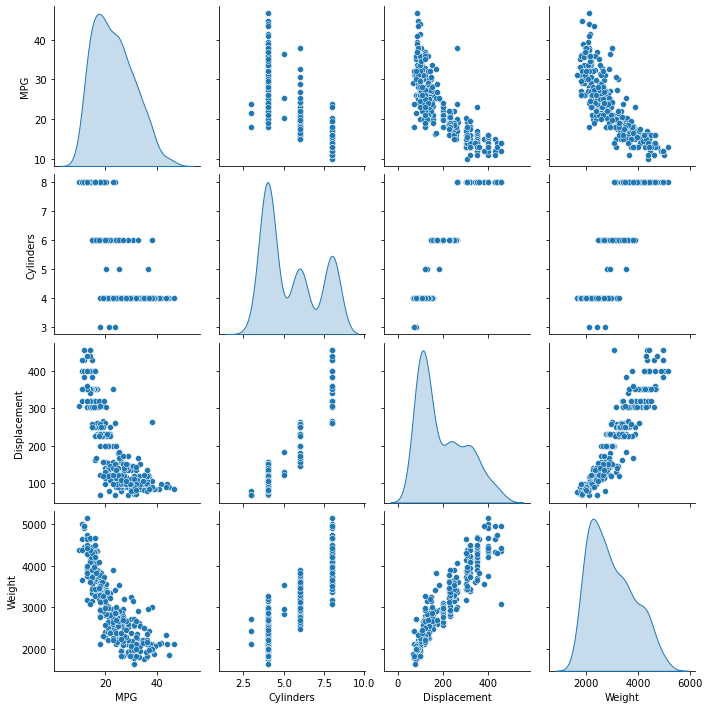

In [9]:
# look at joint plots
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [10]:
# also look at statistics of the features
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [11]:
# split labels from features
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [12]:
# the features have wide ranges, need to normalize
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Build model

In [13]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1) # continuous  value
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model

model = build_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


# Train

In [15]:
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:570.5405,  mae:22.6575,  mse:570.5405,  val_loss:562.1134,  val_mae:22.4744,  val_mse:562.1134,  
....................................................................................................
Epoch: 100, loss:6.0687,  mae:1.7388,  mse:6.0687,  val_loss:8.7325,  val_mae:2.2462,  val_mse:8.7325,  
....................................................................................................
Epoch: 200, loss:5.2629,  mae:1.5773,  mse:5.2629,  val_loss:8.3330,  val_mae:2.1921,  val_mse:8.3330,  
....................................................................................................
Epoch: 300, loss:4.8602,  mae:1.4737,  mse:4.8602,  val_loss:8.5622,  val_mae:2.2118,  val_mse:8.5622,  
....................................................................................................
Epoch: 400, loss:4.5953,  mae:1.4273,  mse:4.5953,  val_loss:9.0511,  val_mae:2.2343,  val_mse:9.0511,  
..............................................................

In [16]:
# look at training stats
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.589205,1.052623,2.589205,10.289239,2.389007,10.289239,995
996,2.620264,1.026591,2.620264,10.834346,2.481344,10.834346,996
997,2.685692,1.099947,2.685692,10.284784,2.365918,10.284784,997
998,2.574035,1.054604,2.574035,10.547382,2.410750,10.547382,998
999,2.668820,1.067069,2.668820,10.790478,2.420825,10.790478,999


Text(0, 0.5, 'MAE [MPG]')

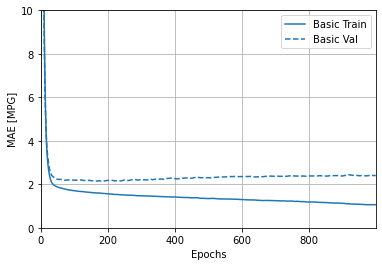

In [18]:
# there seems to be overfitting, try plotting

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric='mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

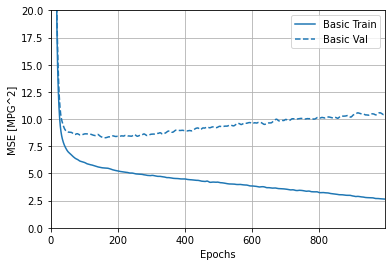

In [19]:
# also plot MSE
plotter.plot({'Basic': history}, metric='mse')
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [20]:
# there is overfitting, so we will add a EarlyStopping callback which tests a training condiction every epoch

model = build_model() # reset model

# check 10 epochs to see if val_loss has improvement, if not, early stop
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(
     normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:582.1482,  mae:22.9017,  mse:582.1482,  val_loss:571.8543,  val_mae:22.6356,  val_mse:571.8543,  
.............................................................

Text(0, 0.5, 'MAE [MPG]')

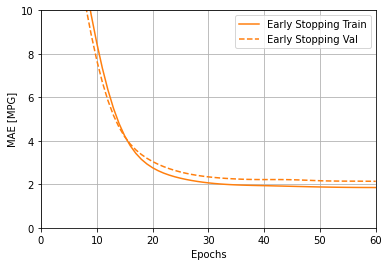

In [21]:
# plot again
plotter.plot({'Early Stopping': early_history}, metric='mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

# Evaluation

In [22]:
# eval on test set
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.9631 - mae: 1.9596 - mse: 5.9631
Testing set Mean Abs Error:  1.96 MPG


# Prediction

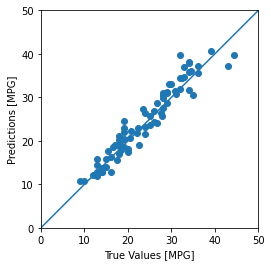

In [23]:
# predict test set
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

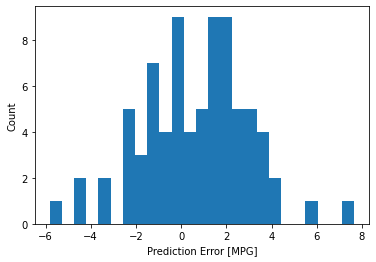

In [24]:
# the plot looks predicting well, look at error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")